<a href="https://colab.research.google.com/github/Pisarenkova/KT_2025/blob/main/pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Loss: 0.8448766469955444
Epoch 100, Loss: 0.2311447262763977
Epoch 200, Loss: 0.15627528727054596
Epoch 300, Loss: 0.11068544536828995
Epoch 400, Loss: 0.08274607360363007
Epoch 500, Loss: 0.0614948645234108
Epoch 600, Loss: 0.046075381338596344
Epoch 700, Loss: 0.03558185324072838
Epoch 800, Loss: 0.027529194951057434
Epoch 900, Loss: 0.020905878394842148


<ipython-input-7-50633263ac6e>:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32)


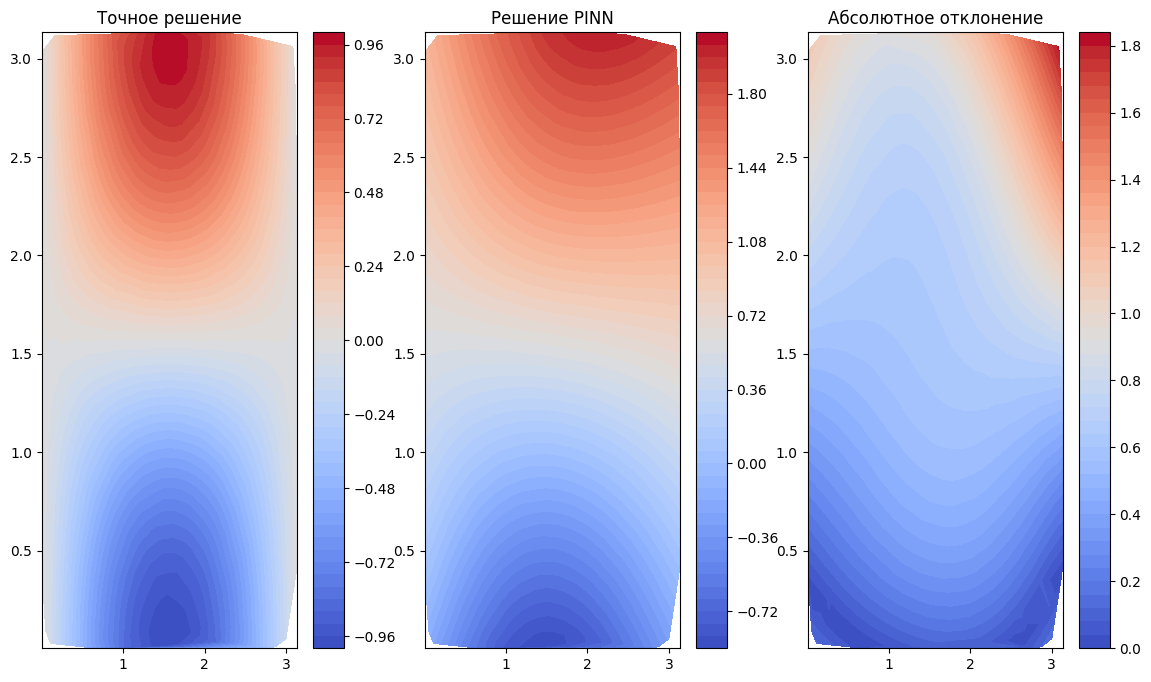

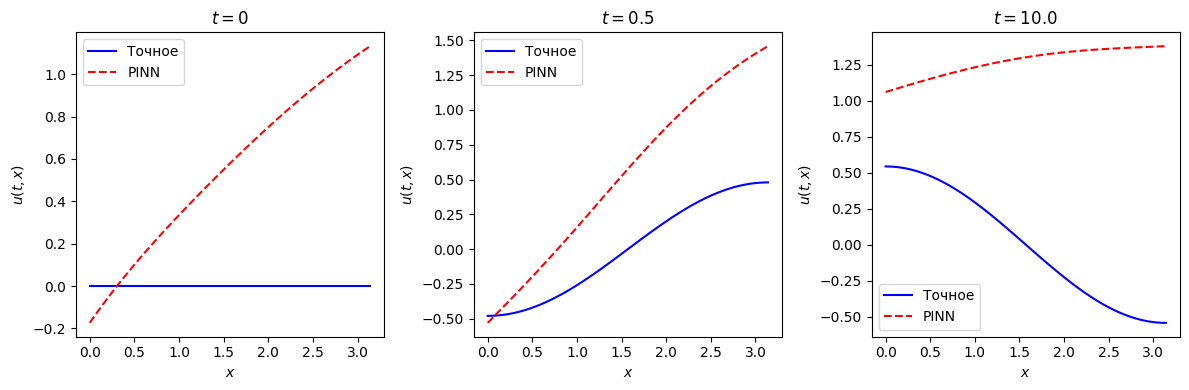

<ipython-input-7-50633263ac6e>:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32)


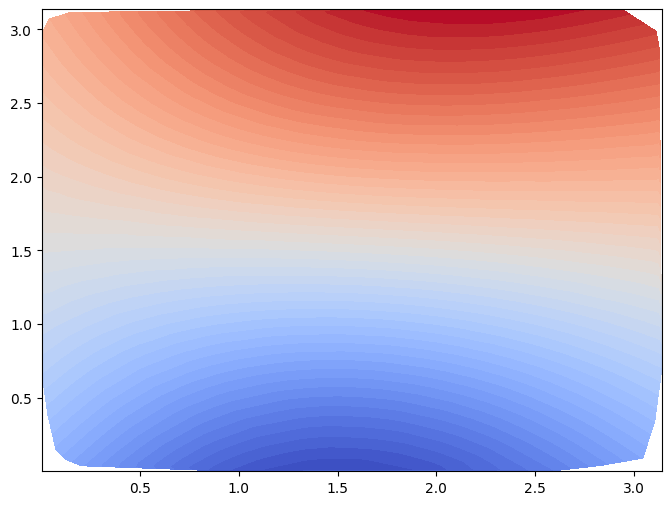

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def exact_solution(x, k=1):
    return -torch.sin(k * x[:, 0]) * torch.cos(x[:, 1])

def f(x, k=1):
    return -k**2 * torch.sin(k * x[:, 0]) * torch.cos(x[:, 1])

def g(x):
    return exact_solution(x).view(-1, 1)

def sample_domain(num_points):
    return torch.rand(num_points, 2, device=device) * np.pi

def sample_boundary(num_points):
    x0 = torch.rand(num_points, device=device) * np.pi
    x1 = torch.zeros(num_points, device=device)
    return torch.stack([x0, x1], dim=1)

class PINN(nn.Module):
    def __init__(self, layer_sizes):
        super(PINN, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.Tanh())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def compute_loss(model, x_interior, x_boundary):
    x_interior.requires_grad_(True)

    u_interior = model(x_interior)

    grad_u = torch.autograd.grad(u_interior, x_interior,
                                 grad_outputs=torch.ones_like(u_interior),
                                 create_graph=True)[0]

    u_xx = torch.autograd.grad(grad_u[:, 0], x_interior,
                               grad_outputs=torch.ones_like(grad_u[:, 0]),
                               create_graph=True)[0][:, 0]

    u_yy = torch.autograd.grad(grad_u[:, 1], x_interior,
                               grad_outputs=torch.ones_like(grad_u[:, 1]),
                               create_graph=True)[0][:, 1]

    loss_pde = torch.mean((u_xx + u_yy + f(x_interior))**2)

    u_boundary = model(x_boundary)
    u_exact_boundary = g(x_boundary)

    loss_bc = torch.mean((u_boundary - u_exact_boundary)**2)

    return loss_pde + loss_bc

num_domain = 10000
num_boundary = 1000
x_interior = sample_domain(num_domain)
x_boundary = sample_boundary(num_boundary)

layer_sizes = [2, 100, 100, 1]
model = PINN(layer_sizes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 1000
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = compute_loss(model, x_interior, x_boundary)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")



def visualize_solution(model):
    x = sample_domain(1000)
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_exact = g(x_tensor).detach().numpy().flatten()

    model.eval()
    with torch.no_grad():
        y_pred = model(x_tensor).cpu().numpy().flatten()

    plt.figure(figsize=(14, 8))

    titles = ["Точное решение", "Решение PINN", "Абсолютное отклонение"]
    data = [y_exact, y_pred, np.abs(y_exact - y_pred)]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.tricontourf(x[:, 0], x[:, 1], data[i], levels=50, cmap="coolwarm")
        plt.colorbar()
        plt.title(titles[i])

    t_values = [0, 0.5, 10.0]
    x_slice = np.linspace(0.0, np.pi, 100)

    plt.figure(figsize=(12, 4))

    for i, t in enumerate(t_values):
        x_test = np.column_stack([np.full_like(x_slice, t), x_slice])
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
        y_exact = exact_solution(x_test_tensor).detach().numpy().flatten()

        with torch.no_grad():
            y_pred = model(x_test_tensor).cpu().numpy().flatten()

        plt.subplot(1, 3, i + 1)
        plt.plot(x_slice, y_exact, 'b-', label="Точное")
        plt.plot(x_slice, y_pred, 'r--', label="PINN")
        plt.xlabel(r"$x$")
        plt.ylabel(r"$u(t, x)$")
        plt.title(r"$t = {}$".format(t))
        plt.legend()

    plt.tight_layout()
    plt.show()

def animate_solution(model, num_frames=10):
    fig, ax = plt.subplots(figsize=(8, 6))
    x = sample_domain(1000)
    x_tensor = torch.tensor(x, dtype=torch.float32)

    predictions = []
    model.eval()
    with torch.no_grad():
        for _ in range(num_frames):
            predictions.append(model(x_tensor).cpu().numpy().flatten())

    def update(frame):
        ax.clear()
        ax.tricontourf(x[:, 0], x[:, 1], predictions[frame], levels=50, cmap="coolwarm")

    ani = animation.FuncAnimation(fig, update, frames=len(predictions), repeat=False)
    ani.save('solution_animation.mp4', writer='ffmpeg', fps=2)

visualize_solution(model)

animate_solution(model)
